In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import DFGLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

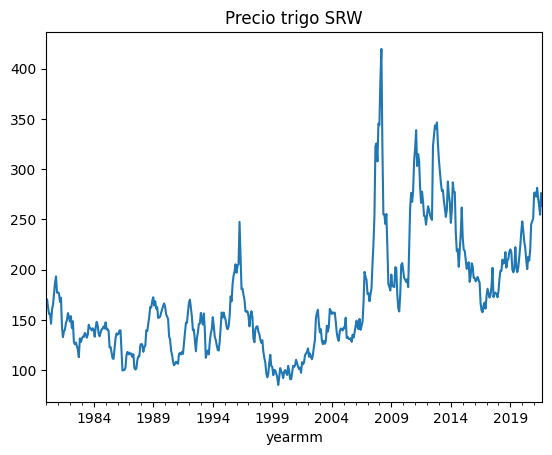

In [4]:
df = pd.read_stata("wheat.dta")
# Variable de tiempo
df = df.set_index("yearmm")

# Serie original
df["wheat_srw"].plot(title="Precio trigo SRW")
plt.show()

### Obetenemos el retorno logarítimoco del trigo

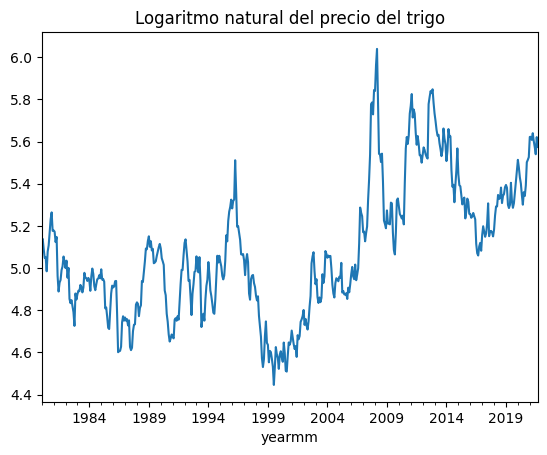

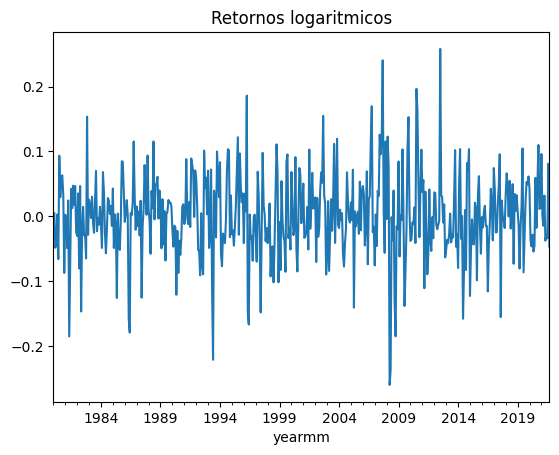

In [27]:
# Logaritmo natural
df["lws"] = np.log(df["wheat_srw"])
#Aca tenemos los retornos. 
df["lws"].plot(title="Logaritmo natural del precio del trigo")
plt.show()
# Primera diferencia (retornos logarítmicos)
df["dlws"] = df["lws"].diff()
df["dlws"].plot(title="Retornos logaritmicos")
plt.show()



### Corremos dfgls, en stata tiene por defecto con tendencia, asi que lo imitamos
Recordamos el test de df: 

- $ H_0: \rho-1=0 $  (No estacionaria)
- $ H_1: |\rho-1| <0 $ (Estacionaria)

Lo que busco es rechazar H0 porque quiero que sea ESTACIONARIA, se rechaza del lado de la cola izquierda

In [6]:
# DFGLS (por defecto incluye tendencia determinística)
dfgls_test = DFGLS(df["dlws"].dropna(), trend="ct")  
print("DFGLS con tendencia:\n", dfgls_test.summary())

DFGLS con tendencia:
       Dickey-Fuller GLS Results      
Test Statistic                 -7.971
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.45 (1%), -2.89 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Aca me dice que es significativo, en el lag8 con el criterio AIC que es el que usa por defecto. 
Estos rezagos son los rezagos del test de DF. El número máximo de rezagos se seleccionan automaticamente con el criterio de Schwert (1989) y luego se va bajando hasta cumplir con el criterio de automatíon, 
en este caso el que es por defecto que es AIC.
Si se incluye constante y tendencia quedaria la ecuacion así

$$ \Delta y_t =c+(\rho -1)y_{t-1}+dt+rezgos+\epsilon_t$$

### ADF con 8 la cantidad optima de rezagos y tendencia
### Verificamos que esto da igual que con stata

In [17]:
adf_test_8 = adfuller(df["dlws"].dropna(), maxlag=8, regression="ct", autolag=None)
print("ADF lags=8 trend:", adf_test_8)
print("ADF lags=8 trend estadistico:", adf_test_8[0])
print("ADF lags=8 trend p-value:", adf_test_8[1])
print("ADF LAGS: ", adf_test_8[2])
print("ADF observaciones:", adf_test_8[3])
print("ADF lags=8 trend criticos:", adf_test_8[4])

ADF lags=8 trend: (-8.329345188285268, 1.2396688672488437e-11, 8, 491, {'1%': -3.9773271377591177, '5%': -3.4194696160270004, '10%': -3.1323324576820575})
ADF lags=8 trend estadistico: -8.329345188285268
ADF lags=8 trend p-value: 1.2396688672488437e-11
ADF LAGS:  8
ADF observaciones: 491
ADF lags=8 trend criticos: {'1%': -3.9773271377591177, '5%': -3.4194696160270004, '10%': -3.1323324576820575}


### Ahora quiero correr el DFA y que me muestre los resultados de la regresion. 
### Validamos que los resultados fueron los mismos que con stata

In [19]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.tsatools import add_trend, lagmat

# Serie original
y = df['dlws'].dropna()

# Diferencias
dy = y.diff().dropna()

# Variable dependiente Δy_t (recortada para alinear con rezagos)
Y = dy[8:]  

# y_(t-1)
y_lag1 = y.shift(1)

# Δy_(t-1) ... Δy_(t-8) como DataFrame
dy_lags = pd.DataFrame(lagmat(dy, maxlag=8, trim='both'),
                       index=dy.index[8:],  # alineo índices
                       columns=[f'dy_lag{i}' for i in range(1, 9)])

# Concateno todo
X = pd.concat([y_lag1, dy_lags], axis=1).dropna()
X.columns = ['y_lag1'] + [f'dy_lag{i}' for i in range(1, 9)]

# Agrego constante + tendencia
X = add_trend(X, trend='ct')  # 'c'=constante, 'ct'=constante+tendencia

# Ajusto OLS
Y = Y.loc[X.index]  # alineo dependiente con X
model = sm.OLS(Y, X).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                   dlws   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     37.16
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           9.23e-54
Time:                        12:44:49   Log-Likelihood:                 664.90
No. Observations:                 491   AIC:                            -1308.
Df Residuals:                     480   BIC:                            -1262.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_lag1        -1.0766      0.129     -8.329      0.0

### Acá tabien se puede ver que el trend determinísitco tiene un p-value no significativo, con lo cual lo que tenemos que hacer es sacar la tendencia

In [20]:
# Serie original
y = df['dlws'].dropna()

# Diferencias
dy = y.diff().dropna()

# Variable dependiente Δy_t (recortada para alinear con rezagos)
Y = dy[8:]  

# y_(t-1)
y_lag1 = y.shift(1)

# Δy_(t-1) ... Δy_(t-8) como DataFrame
dy_lags = pd.DataFrame(lagmat(dy, maxlag=8, trim='both'),
                       index=dy.index[8:],  # alineo índices
                       columns=[f'dy_lag{i}' for i in range(1, 9)])

# Concateno todo
X = pd.concat([y_lag1, dy_lags], axis=1).dropna()
X.columns = ['y_lag1'] + [f'dy_lag{i}' for i in range(1, 9)]

# Agrego constante + tendencia
X = add_trend(X, trend='c')  # 'c'=constante, 'ct'=constante+tendencia

# Ajusto OLS
Y = Y.loc[X.index]  # alineo dependiente con X
model = sm.OLS(Y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   dlws   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     41.25
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           1.93e-54
Time:                        12:51:28   Log-Likelihood:                 664.56
No. Observations:                 491   AIC:                            -1309.
Df Residuals:                     481   BIC:                            -1267.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_lag1        -1.0678      0.129     -8.293      0.0

### El problema es que ahora que sabemos que la tendencia no es significativa el lag=8 puede cambiar, asi que deberíamos correr nuevamente la regresion para DFGLS

In [22]:
# DFGLS (por defecto incluye tendencia determinística)
dfgls_test = DFGLS(df["dlws"].dropna(), trend="c")  
print("DFGLS con tendencia:\n", dfgls_test.summary())

DFGLS con tendencia:
       Dickey-Fuller GLS Results      
Test Statistic                 -8.224
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -2.61 (1%), -1.99 (5%), -1.67 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Aca no hay diferencia con los lags.

### Algunos ejemplos de regagos y tendencias en python

In [24]:
# ADF con 1 rezago y tendencia
adf_test_1 = adfuller(df["dlws"].dropna(), maxlag=1, regression="ct", autolag=None)
print("ADF lags=1 trend:", adf_test_1)

# DFGLS sin tendencia
dfgls_test_nt = DFGLS(df["dlws"].dropna(), trend="c")  
print("DFGLS sin tendencia:\n", dfgls_test_nt.summary())

# ADF sin tendencia, lags=8
adf_test_8_nt = adfuller(df["dlws"].dropna(), maxlag=8, regression="c", autolag=None)
print("ADF lags=8 sin tendencia:", adf_test_8_nt)

# ADF sin tendencia, lags=1
adf_test_1_nt = adfuller(df["dlws"].dropna(), maxlag=1, regression="c", autolag=None)
print("ADF lags=1 sin tendencia:", adf_test_1_nt)


ADF lags=1 trend: (-14.986715555316822, 2.219848116888445e-22, 1, 498, {'1%': -3.977064629068685, '5%': -3.419342866536224, '10%': -3.1322579754349085})
DFGLS sin tendencia:
       Dickey-Fuller GLS Results      
Test Statistic                 -8.224
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -2.61 (1%), -1.99 (5%), -1.67 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
ADF lags=8 sin tendencia: (-8.29320489183114, 4.207181662362939e-13, 8, 491, {'1%': -3.4437386290417082, '5%': -2.867444458865948, '10%': -2.5699148492415413})
ADF lags=1 sin tendencia: (-14.990006296631783, 1.1289925571727804e-27, 1, 498, {'1%': -3.4435494520411605, '5%': -2.8673612117611267, '10%': -2.5698704830567247})


# Conclusion
- Primero se corre el DFGLS, con eso se obtiene la cantidad de lags. 
- Con esos lags se corre el df, con constante y tendencia
- si se puede se saca la tendencia y se vuelve al paso 1. 
- Ahi se concluye que se rechaza o no la H0 para saber si es estacionaria
- Decimos que la serie de precios es I(1)

### ahora vemos el correlograma, la funcion de autocorrelacion (a ver si es MA, si hay estacionalidad)

In [29]:
df

,wheat_srw,wheat_hrw,lws,dlws,test
yearmm,,,,,
1980-01-01,169.71,175.630005,5.134091,NaN,NaN
1980-02-01,170.49,172.699997,5.138677,0.004586,0.78
1980-03-01,162.40,163.509995,5.090062,-0.048614,-8.09
1980-04-01,155.80,156.529999,5.048573,-0.041489,-6.60
1980-05-01,156.20,161.300003,5.051137,0.002564,0.40
...,...,...,...,...,...
2021-05-01,270.98,297.250000,5.602045,-0.037661,-10.40
2021-06-01,263.48,285.549988,5.573977,-0.028068,-7.50
2021-07-01,254.67,294.269989,5.539969,-0.034009,-8.81


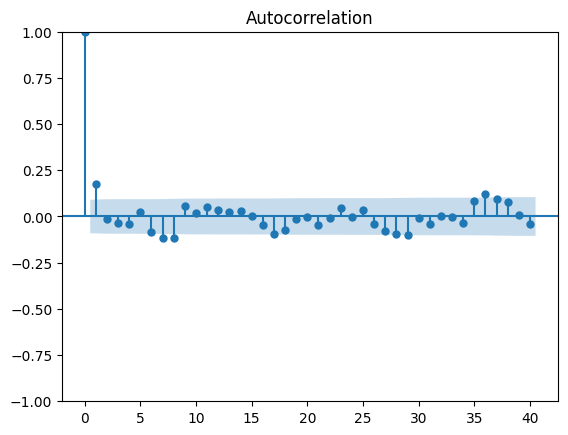

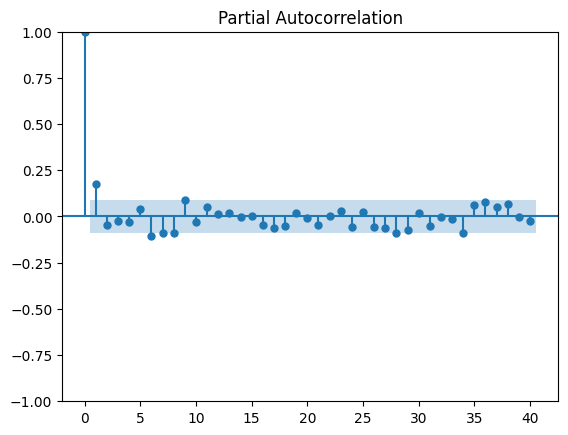

In [31]:
df = df[df.index <= "2018-12-01"]


plot_acf(df["dlws"].dropna(), lags=40)
plt.show()

plot_pacf(df["dlws"].dropna(), lags=40)
plt.show()


### El primer lag se desestima porque es siempre 1 (lag 0), dado que es la correlacion consigo misma. 
En la función de autocorrelacion (MA), vemos que se escapa de la banda en 1,7 y 8
En la funcion de autocorrelacion parcial (AR) se escapa en 1 y 6. 
Podemos suponer que es un ARMA(1,1), ARMA(1,7), ARMA(1,8) ARMA(6,1), ARMA(6,7), ARMA(6,8)

### Con estos guesses hacermos los ARIMA

In [33]:
# Estimación de ARIMA
model1 = ARIMA(df["dlws"].dropna(), order=(1,0,1)).fit()
print(model1.summary())

model2 = ARIMA(df["dlws"].dropna(), order=(1,0,8)).fit()
print(model2.summary())

# Este modelo se corresponde a arima dlws, ar(1) ma(1,7,8) estat ic
model3 = ARIMA(df["dlws"].dropna(), order=(1,0,8), seasonal_order=(0,0,0,0)).fit()
print(model3.summary())


# Ejemplo: ARIMA(1,0, [7,8]) -> en Python hay que especificar manualmente
# Vamos a usar (p,d,q) y probar distintas combinaciones
model_final = ARIMA(df["dlws"].dropna(), order=(1,0,2)).fit()  
print(model_final.summary())

/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information 

                               SARIMAX Results                                
Dep. Variable:                   dlws   No. Observations:                  467
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 619.513
Date:                Fri, 29 Aug 2025   AIC                          -1231.026
Time:                        18:32:36   BIC                          -1214.441
Sample:                    02-01-1980   HQIC                         -1224.499
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.004      0.154      0.877      -0.006       0.008
ar.L1         -0.0231      0.271     -0.085      0.932      -0.555       0.508
ma.L1          0.2056      0.265      0.775      0.4

/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   dlws   No. Observations:                  467
Model:                 ARIMA(1, 0, 8)   Log Likelihood                 628.695
Date:                Fri, 29 Aug 2025   AIC                          -1235.389
Time:                        18:32:36   BIC                          -1189.780
Sample:                    02-01-1980   HQIC                         -1217.440
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.174      0.862      -0.005       0.006
ar.L1         -0.3637      0.286     -1.273      0.203      -0.924       0.196
ma.L1          0.5501      0.291      1.892      0.0

/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum 

In [34]:

# ==============================================
# Paso 3: Diagnóstico del modelo
# ==============================================

# Residuos
resid = model_final.resid

# Test de Ljung-Box (equivalente a Portmanteau)
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(resid, lags=[10], return_df=True))

# Verificación de raíces inversas (estabilidad ARMA)
print("Raíces AR:", model_final.arroots)
print("Raíces MA:", model_final.maroots)

      lb_stat  lb_pvalue
10  14.910887   0.135345
Raíces AR: [1.04160329]
Raíces MA: [ 1.00173593 -5.01359441]
